# Calculating Materials Properties with pyiron

Author: [jan-janssen](https://jan-janssen.com)

When working with interatomic potentials, it is commonly difficult to assess the quality of a new interatomic potential. pyiron can accelerate this assessment by providing simulation protocols to calculate pre-defined materials properties. In this example we demonstrate the calculation of the elastic constants and the band structure. 

## Calculate Elastic Constants

Rather than reimplementing its own method to calculate the elastic constants, pyiron relies on existing codes from the community and primarily provides and interface to connect these codes. For calculating the elastic constants we use the [ElaStic](https://doi.org/10.1016/j.cpc.2013.03.010) code. As this code is published under the General Public License (GPL) we load an additional `pyiron_gpl` module.

In [1]:
import pyiron_gpl

Afterwards, just like before the `Project` class is imported from the `pyiron_atomistics` module.

In [2]:
from pyiron_atomistics import Project

We then create a `Project` named `elastic` for the calculation of the elastic matrix and again we remove all existing calculation in this project to have a fresh start. 

In [3]:
pr = Project("materials")
pr.remove_jobs(silently=True)

Following the same steps as in the previous tutorial on calculating energy volume curves, we again create a reference LAMMPS job to specify the atomistic structure and the interatomic potential. 

In [4]:
job_lmp = pr.create.job.Lammps(job_name="lmp")
job_lmp.structure = pr.create.structure.ase.bulk(name="Al", cubic=True)
job_lmp.potential = '1999--Mishin-Y--Al--LAMMPS--ipr1'

The reference job is assinged to the `ElasticMatrixJob` afterwards. This `ElasticMatrixJob` is again an `GenericMaster` job which does not interface to a specific simulation code but rather coordinates the execution of multiple individual calculation to calculate a combined property, in this case the elastic constants. 

In [5]:
job_elastic = pr.create.job.ElasticMatrixJob(job_name="elastic")
job_elastic.ref_job = job_lmp
job_elastic.input

,Parameter,Value,Comment
0,num_of_points,5,number of sample point per deformation directions
1,fit_order,2,order of the fit polynom
2,eps_range,0.005,strain variation
3,relax_atoms,True,relax atoms in deformed structure
4,sqrt_eta,True,calculate self-consistently sqrt of stress matrix eta


The `ElasticMatrixJob` can then be executed by calling the `run()` method. Once again by leveraging the same abstract job class for individual calculation like the LAMMPS job object as well as `GenericMaster` jobs like the `ElasticMatrixJob` both jobs can be distributed to queuing systems and so on. Here the job is just executed in-line with the python process of the jupyter notebook, which is called `modal` execution in pyiron.  

In [6]:
job_elastic.run()

The job elastic was saved and received the ID: 21797
The job s_e_0 was saved and received the ID: 21798
The job s_01_e_m0_00500 was saved and received the ID: 21799
The job s_01_e_m0_00250 was saved and received the ID: 21800
The job s_01_e_0_00250 was saved and received the ID: 21801
The job s_01_e_0_00500 was saved and received the ID: 21802
The job s_08_e_m0_00500 was saved and received the ID: 21803
The job s_08_e_m0_00250 was saved and received the ID: 21804
The job s_08_e_0_00250 was saved and received the ID: 21805
The job s_08_e_0_00500 was saved and received the ID: 21806
The job s_23_e_m0_00500 was saved and received the ID: 21807
The job s_23_e_m0_00250 was saved and received the ID: 21808
The job s_23_e_0_00250 was saved and received the ID: 21809
The job s_23_e_0_00500 was saved and received the ID: 21810


After the successful execution the elastic matrix can be loaded from the output: 

In [7]:
job_elastic["output/elasticmatrix"]["C"]

array([[114.10393026,  60.51098917,  60.51098917,   0.        ,
          0.        ,   0.        ],
       [ 60.51098917, 114.10393026,  60.51098917,   0.        ,
          0.        ,   0.        ],
       [ 60.51098917,  60.51098917, 114.10393026,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  31.67539615,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         31.67539615,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  31.67539615]])

## Calculate the band structure

In analogy to the elastic constants above pyiron also interfaces with the [phonopy](https://phonopy.github.io/phonopy/index.html) package to calculate the bandstructure and total density of states for a given interatomic potential. The great advantage of using these tools via pyiron rather than using them directly is that the interface to set the reference job object to calculate the energies and forces for the particular materials property is always the same. So once again we define a LAMMPS reference job which is used to calculate the bandstructure. 

In [8]:
job_lmp = pr.create.job.Lammps(job_name="lmp")
job_lmp.structure = pr.create.structure.ase.bulk(name="Al", cubic=True)
job_lmp.potential = '1999--Mishin-Y--Al--LAMMPS--ipr1'

The reference job is afterwards assigned to the `PhonopyJob` which itself is again a `GenericMaster` job:

In [9]:
job_phonon = pr.create.job.PhonopyJob(job_name="phonon")
job_phonon.ref_job = job_lmp
job_phonon.input

,Parameter,Value,Comment
0,interaction_range,10.000000,"Minimal size of supercell, Ang"
1,factor,15.633302,Frequency unit conversion factor (default for VASP)
2,displacement,0.010000,"atoms displacement, Ang"
3,dos_mesh,20.000000,mesh size for DOS calculation
4,primitive_matrix,NaN,
5,number_of_snapshots,NaN,"int or None, optional. Number of snapshots of supercells with random displacements. Random displacements are generated displacing all atoms in random directions with a fixed displacement distance ..."


The `PhonopyJob` is executed by calling the run method: 

In [10]:
job_phonon.run()

The job phonon was saved and received the ID: 21811
The job lmp_0 was saved and received the ID: 21812


Finally, just like we did for the energy volume curve calculation in the previous tutorial, we can use the internal plot functions of the `PhonopyJob` to plot the band structure and the total density of states. 

<Axes: title={'center': 'Bandstructure'}, xlabel='Bandpath', ylabel='Frequency [THz]'>

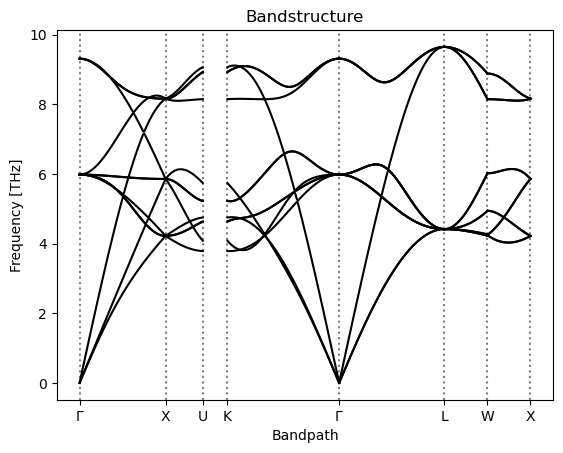

In [11]:
job_phonon.plot_band_structure()

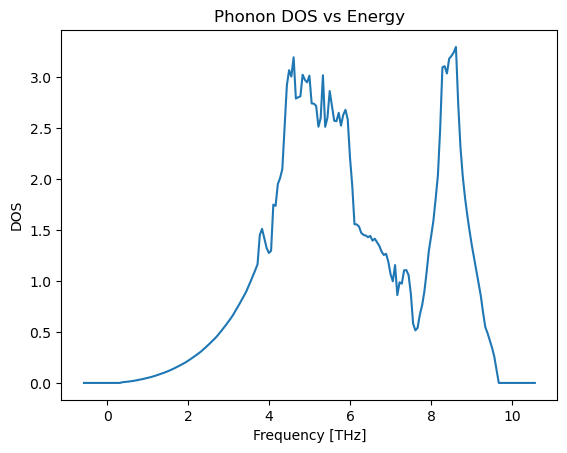

In [12]:
job_phonon.plot_dos()

To go beyond the harmonic approximation and include the volume expansion in terms of the quasi-harmonic approximation, we can use the `QuasiHarmonicJob` class which executes a `PhonopyJob` for various volumes and provides the utility functions to calculate the free energy in the resulting quasi-harmonic approximation. This functionality is explained in more detail in the [virtual course](https://pyiron.org/phasediagram-workshop-2020/ThermodynamicProperties.html) on the pyiron website. 

## Fitting machine learning interatomic potentials

The fitting of machine learning interatomic potentials requires a separate tutorial, so it is not included in this presentation. Instead it was discussed in the [Workshop: From Electrons to Phase Diagrams](http://potentials.rub.de/2022/index.php). The recordings of this workshop as well as the interactive jupyter notebooks are [available online](http://pyiron.org/potentials-workshop-2022/intro.html). We plan to extend this interface and in particular the [FitSNAP](https://github.com/FitSNAP) package. So if these topics are interesting to you feel free to reach out on Github or contact the pyiron developers directly. 

## Summary

Beyond the ability to rapid-prototype and up-scale your own simulation protocols, pyiron already provides interfaces to a series of material property calculators and continues to expand this functionality, with the goal to make atomistic calculations more accessible to a larger audience. 